In [2]:
import mysql.connector
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os
import _pickle as cPickle

def save_pvalues(dict):
    pickle_path = 'D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/pvalues.pkl'
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as fp:
            pvalue_dict = cPickle.load(fp)
    else:
        pvalue_dict = {}
    
    for key in dict.keys():
        pvalue_dict[key] = dict[key]
     
    with open(pickle_path, 'wb') as fp:
        cPickle.dump(pvalue_dict, fp)

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="userDB"
)

df = pd.read_sql('SELECT * FROM survey_info', con=mydb)

users=[98, 133, 140, 161, 168, 175, 182, 189, 196, 203, 210, 224, 231, 238, 245, 252, 259]
# df = df[(df.id >= 98) & (df.id != 126) & (df.id != 217)].drop_duplicates()
df = df[df["id"].isin(users)].drop_duplicates()

question_columns = list(df.columns[4:-3])
columns = list(df.columns)
columns

['id',
 'software',
 'software_order',
 'session',
 'type_quick',
 'type_accurate',
 'many_errors',
 'corr_ease',
 'recovery',
 'audio',
 'free_response_1',
 'free_response_2']

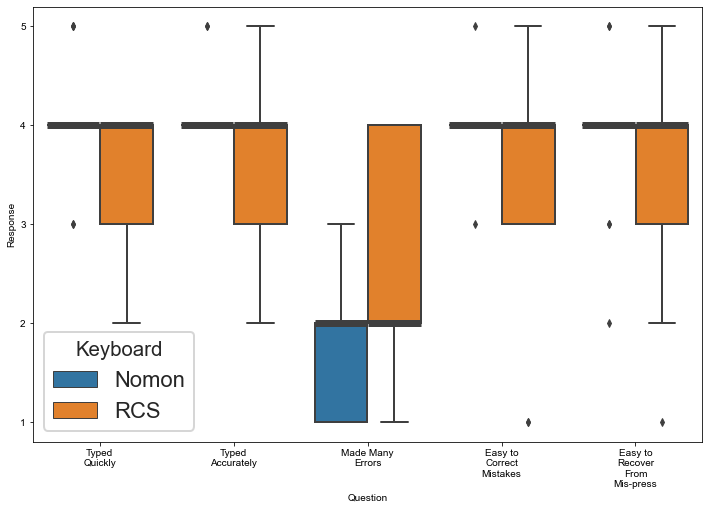

In [3]:
x_label_dict = {"type_quick": "Typed\nQuickly", "type_accurate": "Typed\nAccurately", 
                "many_errors": "Made Many\nErrors", "corr_ease": "Easy to\nCorrect\nMistakes",
                "recovery": "Easy to\nRecover\nFrom\nMis-press", "audio": "Audio\nFeedback\nHelpfull"}
keyboard_name_dict = {"A": "Nomon", "B": "RCS"}
long_df = pd.DataFrame(columns=["Question", "Keyboard", "Response"])

session_num=9
for row in df[df.session == session_num].values:
    for question in question_columns:
        question_index = columns.index(question)  
        software_index = columns.index("software")
        
        long_df = long_df.append({"Question": x_label_dict[question], 
                        "Keyboard": keyboard_name_dict[row[software_index]], 
                        "Response": int(row[question_index])}, ignore_index=True)
long_df["Response"] = pd.to_numeric(long_df["Response"])

a4_dims = (12, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
sns.set_context("poster")
sns.set_style("whitegrid")

box_plot = sns.boxplot(data=long_df, x="Question", y="Response", hue="Keyboard", ax=ax, linewidth=2)

ax = box_plot.axes
lines = ax.get_lines()

for median_line in lines[4:len(lines):6]:
    median_line.set_solid_capstyle('butt')
    median_line.set_linewidth(7)
    median_line.set_alpha(1)

plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/survey_1.png")

In [3]:
pvalues = {}
for question in list(x_label_dict.values())[:-1]:
    nomon_responses = long_df[(long_df.Question == question) & (long_df.Keyboard == "Nomon")].Response.values
    rowcol_responses = long_df[(long_df.Question == question) & (long_df.Keyboard == "RCS")].Response.values
    
    print(question, np.mean(nomon_responses), np.std(nomon_responses), np.mean(rowcol_responses), np.std(rowcol_responses), "\n")
    # question_data = np.vstack([nomon_responses, rowcol_responses]).T
    cur_pvalue = stats.mannwhitneyu(nomon_responses, rowcol_responses).pvalue
    
    pvalues["Session "+str(session_num)+"\n"+question] = cur_pvalue

save_pvalues(pvalues)
pvalues

Typed
Quickly 4.076923076923077 0.6153846153846155 3.3846153846153846 0.737820234355803 

Typed
Accurately 4.153846153846154 0.36080121229411 3.769230769230769 0.8904489925223251 

Made Many
Errors 1.9230769230769231 0.7297563831157798 2.6923076923076925 0.9910845174403944 

Easy to
Correct
Mistakes 4.0 0.3922322702763681 3.6153846153846154 1.2733034890189883 

Easy to
Recover
From
Mis-press 3.8461538461538463 0.7692307692307693 3.4615384615384617 1.2162606385262995 



{'Session 9\nTyped\nQuickly': 0.014416958647714695,
 'Session 9\nTyped\nAccurately': 0.11350844651306863,
 'Session 9\nMade Many\nErrors': 0.031921064134391976,
 'Session 9\nEasy to\nCorrect\nMistakes': 0.34680487945904936,
 'Session 9\nEasy to\nRecover\nFrom\nMis-press': 0.2395385610459123}

In [4]:

x_label_dict = {"type_quick": "Typed Quickly", "type_accurate": "Typed Accurately", 
                "many_errors": "Made Many Errors", "corr_ease": "Easy to Correct Mistakes",
                "recovery": "Easy to Recover From Mis-press", "session": "Session", "software": "Keyboard"}
latex_df = df.groupby(['session', 'software']).agg({"type_quick": ['mean', 'std'], "type_accurate": ['mean', 'std'],
                                                    "many_errors": ['mean', 'std'], "corr_ease": ['mean', 'std'],
                                                    "recovery": ['mean', 'std']})
latex_df = latex_df.round(1)
latex_df = latex_df.reset_index()
# latex_df = latex_df.rename(columns=x_label_dict)
latex_df = latex_df.replace('A', "Nomon")
latex_df = latex_df.replace('B', "RCS")

print(latex_df.to_latex(index=False))

\begin{tabular}{rlrrrrrrrrrr}
\toprule
session & software & \multicolumn{2}{l}{type\_quick} & \multicolumn{2}{l}{type\_accurate} & \multicolumn{2}{l}{many\_errors} & \multicolumn{2}{l}{corr\_ease} & \multicolumn{2}{l}{recovery} \\
        &       mean &  std &          mean &  std &        mean &  std &      mean &  std &     mean &  std \\
\midrule
      2 &    Nomon &        3.4 &  0.9 &           3.5 &  1.2 &         2.4 &  1.3 &       3.5 &  1.0 &      3.5 &  1.1 \\
      2 &      RCS &        3.2 &  1.2 &           4.1 &  0.9 &         2.7 &  1.0 &       3.7 &  0.8 &      2.8 &  1.2 \\
      5 &    Nomon &        4.2 &  0.7 &           4.2 &  0.5 &         2.0 &  0.7 &       4.1 &  0.5 &      3.8 &  0.9 \\
      5 &      RCS &        3.3 &  1.3 &           3.7 &  0.9 &         2.7 &  1.2 &       3.9 &  1.0 &      3.6 &  1.0 \\
      9 &    Nomon &        4.1 &  0.6 &           4.2 &  0.4 &         1.9 &  0.8 &       4.0 &  0.4 &      3.8 &  0.8 \\
      9 &      RCS &        3.4 &

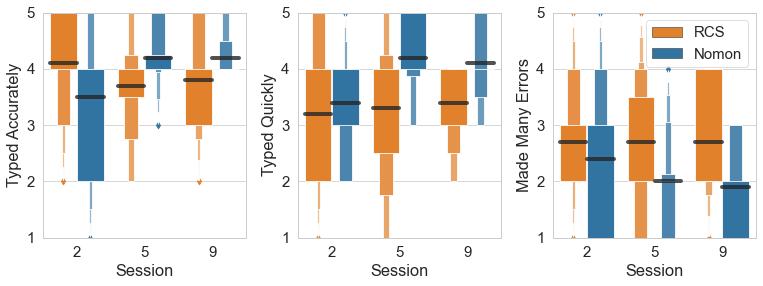

In [21]:
plot_df = df[df.session < 10]
plot_df = plot_df.replace('A', "Nomon")
plot_df = plot_df.replace('B', "RCS")

def get_mean(line_index, stat):
    session = [2, 5, 9][line_index//2]
    software = 1-(line_index % 2)
    return latex_df[latex_df["session"] == session][stat].values[software][0]

colors = ["tab:orange", "tab:blue"]
sns.set_palette(colors)
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3,figsize=(11,4))
fig.tight_layout(w_pad=0.5)

axes = list(axes)

for index, question in enumerate([ "type_accurate", "type_quick", "many_errors"]):
    ax = axes[index]
    sns.boxenplot(x="session", y=question, hue="software", data=plot_df, ax=ax)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel(x_label_dict[question])
    ax.set_xlabel("Session")
    ax.set_ylim(top=5, bottom=1)
    for (i, l) in enumerate(ax.lines):
        # l.set_color('w')
        x_data = l.get_data()[0]
        y = get_mean(i, question)
        l.set_data([x_data, np.array([y, y])])
        l.set_linewidth(4)
        l.set_alpha(0.8)   
    
    if question != "many_errors":
        ax.get_legend().remove()
    else:
         ax.get_legend().set_title('')
    
    plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/survey_test_fig.png", dpi=300)
